In [22]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

### READ IN DAILY DATA

In [53]:
states = pd.read_csv("./daily_data/nyt_states.csv")

counties = pd.read_csv("./daily_data/nyt_counties.csv")

testing = pd.read_csv("./daily_data/covid_tracking.csv")

## Prep County Data

In [54]:
counties["date"] = pd.to_datetime(counties.date, format = "%Y-%m-%d")

counties = counties.sort_values(by = ["county", "date" ]).reset_index(drop = True)

counties.head()

,date,county,state,fips,cases,deaths
0,2020-03-19,Abbeville,South Carolina,45001.0,1,0
1,2020-03-20,Abbeville,South Carolina,45001.0,1,0
2,2020-03-21,Abbeville,South Carolina,45001.0,1,0
3,2020-03-22,Abbeville,South Carolina,45001.0,1,0
4,2020-03-23,Abbeville,South Carolina,45001.0,1,0


In [55]:
unknown_indices = counties[counties.county == "Unknown"].index ## drop state level observations

counties = counties.drop(unknown_indices, axis = 0).reset_index(drop = True)

counties[counties.fips.isnull()].county.unique()

array(['Kansas City', 'New York City'], dtype=object)

In [56]:
kc_indices = counties[counties.county == "Kansas City"].index

ny_indices = counties[counties.county == "New York City"].index

for i in kc_indices:
    
    counties.at[i, "fips"] = -1 #assign non-null value so I can index through all counties by fips
                                #having an issue with shared county names
for j in ny_indices:
    
    counties.at[j, "fips"] = -2
    
#check my work
print(len(counties[counties.fips.isnull()]))

0


In [57]:
counties.head()

,date,county,state,fips,cases,deaths
0,2020-03-19,Abbeville,South Carolina,45001.0,1,0
1,2020-03-20,Abbeville,South Carolina,45001.0,1,0
2,2020-03-21,Abbeville,South Carolina,45001.0,1,0
3,2020-03-22,Abbeville,South Carolina,45001.0,1,0
4,2020-03-23,Abbeville,South Carolina,45001.0,1,0


In [58]:
county_frames = []

for cty in counties.fips.unique():
    
    county_df = counties[counties.fips == cty]
    
    county_df = county_df.sort_values(by = ["date"]).reset_index(drop = True) #ensure correct order
    
    if len(county_df) > 1:
        
        growth_rates = [0]
        
        for k in range(1, len(county_df)):
            
            growth_rates.append((county_df.iloc[k]["cases"] / county_df.iloc[k-1]["cases"]) - 1)
            
        growth_rates = pd.Series(growth_rates).rename("daily_growth_rate")
        
    else:
        
        growth_rates = pd.Series([-1]).rename("daily_growth_rate")
        
    assert len(growth_rates) == len(county_df)

    county_df = pd.concat([county_df, growth_rates], axis = 1)

    county_frames.append(county_df)

In [59]:
all_county = pd.concat(county_frames, axis = 0).reset_index(drop = True)

all_county.head()

,date,county,state,fips,cases,deaths,daily_growth_rate
0,2020-03-19,Abbeville,South Carolina,45001.0,1,0,0.0
1,2020-03-20,Abbeville,South Carolina,45001.0,1,0,0.0
2,2020-03-21,Abbeville,South Carolina,45001.0,1,0,0.0
3,2020-03-22,Abbeville,South Carolina,45001.0,1,0,0.0
4,2020-03-23,Abbeville,South Carolina,45001.0,1,0,0.0


In [60]:
del county_frames

del counties

## Prepare State Data

In [61]:
states["date"] = pd.to_datetime(states.date, format = "%Y-%m-%d")

states = states.sort_values(by = ["state", "date"]).reset_index(drop = True)

In [62]:
state_frames = []

for st in states.fips.unique():
    
    state_df = states[states.fips == st]
    
    state_df = state_df.sort_values(by = ["date"]).reset_index(drop = True) #ensure correct order
    
    if len(state_df) > 1:
        
        growth_rates = [0]
        
        for k in range(1, len(state_df)):
            
            growth_rates.append((state_df.iloc[k]["cases"] / state_df.iloc[k-1]["cases"]) - 1)
            
        growth_rates = pd.Series(growth_rates).rename("daily_growth_rate")
        
    else:
        
        growth_rates = pd.Series([-1]).rename("daily_growth_rate")
        
    assert len(growth_rates) == len(state_df)

    state_df = pd.concat([state_df, growth_rates], axis = 1)

    state_frames.append(state_df)
    
all_state = pd.concat(state_frames, axis = 0).reset_index(drop = True)

all_state.head()

,date,state,fips,cases,deaths,daily_growth_rate
0,2020-03-13,Alabama,1,6,0,0.000000
1,2020-03-14,Alabama,1,12,0,1.000000
2,2020-03-15,Alabama,1,23,0,0.916667
3,2020-03-16,Alabama,1,29,0,0.260870
4,2020-03-17,Alabama,1,39,0,0.344828


In [63]:
from IPython.display import display, HTML

In [64]:
def get_hot_counties(state: str, n_most = 10, all_county = all_county):
    
    state_df = all_county[all_county.state == state].reset_index(drop = True)
    
    hotspots = state_df[state_df.date == state_df.date.max()].sort_values(by = ["cases"], 
                                                                  ascending = False).county.values[:n_most]
    county_dfs = {}
    
    hot_counties = []
    
    for cty in hotspots:
        
        cty_df = state_df[state_df.county == cty].reset_index(drop = True)
        
        county_dfs[cty] = cty_df
        
        d = {}
        
        d["county"] = cty
        
        d["first_case"] = cty_df.date.min()
        
        d["total_cases"] = cty_df.iloc[-1]["cases"]
        
        d["previous_day_growth_rate"] = "{}%".format(
            round(cty_df.iloc[-1]["daily_growth_rate"] * 100, 2))
        
        if len(cty_df) >= 3:
            
            d["3day_avg_growth_rate"] = "{}%".format(
                round(cty_df.iloc[-1:-4:-1]["daily_growth_rate"].mean() * 100, 2))
            
        else:
            
            d["3day_avg_growth_rate"] = "Not Available"
            
        if len(cty_df) >= 7:
            
            d["7day_avg_growth_rate"] = "{}%".format(
                round(cty_df.iloc[-1:-8:-1]["daily_growth_rate"].mean() * 100, 2))
            
        else:
            
            d["7day_avg_growth_rate"] = "Not Available"
            
        hot_counties.append(d)
        
    summary_df = pd.DataFrame(hot_counties)
    
    print("The {} most effected counties in {}:".format(n_most, state))
    
    display(summary_df)
    
    return(county_dfs)
            
def analyze_state(state: str or int or float, all_county = all_county, all_state = all_state):
    
    if type(state) == str:
        
        state = state.capitalize()
        
        state_df = all_state[all_state.state == state].reset_index(drop = True)
        
        if len(state_df) == 0:
            
            state_df = all_state[all_state.state == state.reset_index(drop = True)]
            
            if len(state_df) == 0:
                
                raise NameError("Please ensure state name is spelled correctly")
                
    elif type(state) == int or type(state) == float:
        
        state_df = all_state[all_state.fips == state].reset_index(drop = True)
        
        if len(state_df) == 0:
            
            raise NameError("Please ensure correct FIPS entered")
            
    else:
        
        raise ValueError("Incorrect value passed to state. Please enter state name or state FIPS code")
        
    state_name = state_df.iloc[0]["state"]
    
    if len(state_df) == 1:
        
        return("{} recorded its first case of COVID-19 on {}, with {} total cases".format(
        state_name, state_df.iloc[-1]["date"], state_df.iloc[-1]["cases"]))
    
    else:
        
        print("{} reported its first cases of COVID-19 on {}, and has {} cases as of {}\n".format(
        state_name, state_df.date.min(), state_df.iloc[-1]["cases"], 
        state_df.date.max()))
        
        print("The previous daily growth rate was {}%\n".format(
            round(state_df.iloc[-1]["daily_growth_rate"] * 100, 2) ))
        
        if len(state_df) >= 3:
            
            _3day = state_df.iloc[-1:-4:-1].daily_growth_rate.mean()
            
            print("The 3 day average growth rate was {}%\n".format(
            round(_3day * 100, 2)))
            
        if len(state_df) >= 7:
            
            _7day = state_df.iloc[-1:-8:-1].daily_growth_rate.mean()
            
            print("The 7 day average growth rate was {}%\n".format(
            round(_7day * 100, 2)))
            
        c = get_hot_counties(state_name)
            
        fig, ax = plt.subplots(4, figsize = (15, 25))
        
        ax[0].scatter(state_df.date, state_df.cases, c = "k")
        
        ax[0].plot(state_df.date, state_df.cases)
        
        ax[0].set_title("Total Cases - {}".format(state_name), weight = "bold")
        
        ax[0].set_ylabel("Total Number of Cases", weight = "bold")
        
        ax[0].set_xlabel("Date", weight = "bold")
        
        ax[1].scatter(state_df.date, state_df.daily_growth_rate * 100, c = "k")
        
        ax[1].plot(state_df.date, state_df.daily_growth_rate * 100)
        
        ax[1].set_title("Daily Growth Rate - {}".format(state_name), weight = "bold")
        
        ax[1].set_ylabel("Percentage Growth (Case Numbers) from Previous Day", weight = "bold")
        
        ax[1].set_xlabel("Date", weight = "bold")
        
        for cty in c:
            
            ax[2].plot(c[cty].date, c[cty].cases, label = cty)
            
            ax[2].text(c[cty].iloc[-1]["date"], c[cty].iloc[-1]["cases"], c[cty].iloc[-1]["cases"],
                        horizontalalignment='left', weight = "bold")
            
            ax[3].plot(c[cty].date, c[cty].daily_growth_rate * 100, label = cty)
        
        ax[2].legend(bbox_to_anchor=(0.00, 1), loc='upper left', borderaxespad=0)
        
        ax[2].set_title("Cases by County - {}".format(state_name), weight = "bold")
        
        ax[2].set_ylabel("Number of Cases", weight = "bold")
        
        ax[2].set_xlabel("Date", weight = "bold")
        
        ax[3].legend(bbox_to_anchor=(0.00, 1), loc = "upper left", borderaxespad=0)
        
        ax[3].set_title("Daily Growth Rate by County - {}".format(state_name), weight = "bold")
        
        ax[3].set_ylabel("Percentage Growth (Caase Numbers) from Previous Day", weight = "bold")
        
        ax[3].set_xlabel("Date", weight = "bold")

California reported its first cases of COVID-19 on 2020-01-25 00:00:00, and has 10995 cases as of 2020-04-02 00:00:00

The previous daily growth rate was 12.01%

The 3 day average growth rate was 14.01%

The 7 day average growth rate was 15.34%

The 10 most effected counties in California:


,county,first_case,total_cases,previous_day_growth_rate,3day_avg_growth_rate,7day_avg_growth_rate
0,Los Angeles,2020-01-26,4045,14.98%,17.84%,18.77%
1,San Diego,2020-02-10,966,13.78%,17.06%,16.15%
2,Santa Clara,2020-01-31,956,0.0%,4.12%,8.83%
3,Orange,2020-01-25,606,0.0%,9.64%,13.75%
4,Riverside,2020-03-07,493,32.88%,20.13%,26.84%
5,San Mateo,2020-03-02,453,16.75%,14.11%,13.17%
6,San Francisco,2020-02-02,450,2.97%,6.39%,10.51%
7,Alameda,2020-03-01,417,9.74%,11.13%,11.28%
8,Sacramento,2020-02-21,340,8.28%,16.15%,18.78%
9,San Bernardino,2020-03-15,304,19.69%,41.12%,30.45%


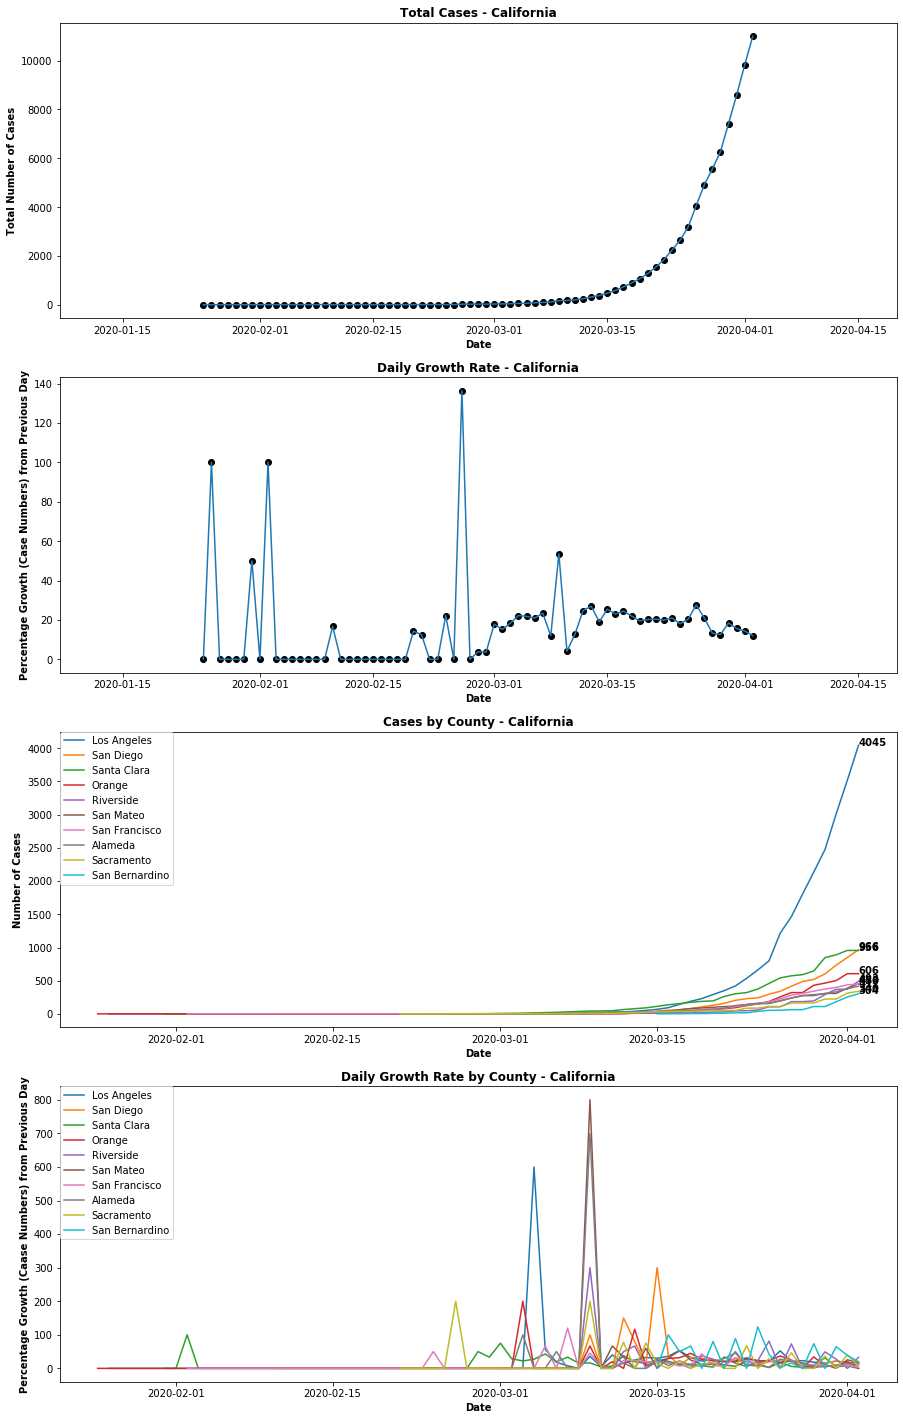

In [65]:
analyze_state("California")

Colorado reported its first cases of COVID-19 on 2020-03-05 00:00:00, and has 3728 cases as of 2020-04-02 00:00:00

The previous daily growth rate was 11.42%

The 3 day average growth rate was 12.37%

The 7 day average growth rate was 14.7%

The 10 most effected counties in Colorado:


,county,first_case,total_cases,previous_day_growth_rate,3day_avg_growth_rate,7day_avg_growth_rate
0,Denver,2020-03-06,643,9.73%,11.45%,13.75%
1,Arapahoe,2020-03-09,441,15.75%,12.75%,20.86%
2,Jefferson,2020-03-05,385,8.15%,15.14%,16.72%
3,El Paso,2020-03-06,340,8.28%,11.6%,13.91%
4,Weld,2020-03-13,329,12.29%,15.26%,17.49%
5,Eagle,2020-03-06,314,6.44%,14.32%,11.76%
6,Adams,2020-03-12,260,21.5%,19.36%,26.97%
7,Douglas,2020-03-05,171,8.23%,12.32%,14.4%
8,Boulder,2020-03-14,132,15.79%,9.78%,10.47%
9,Larimer,2020-03-09,124,15.89%,10.53%,10.74%


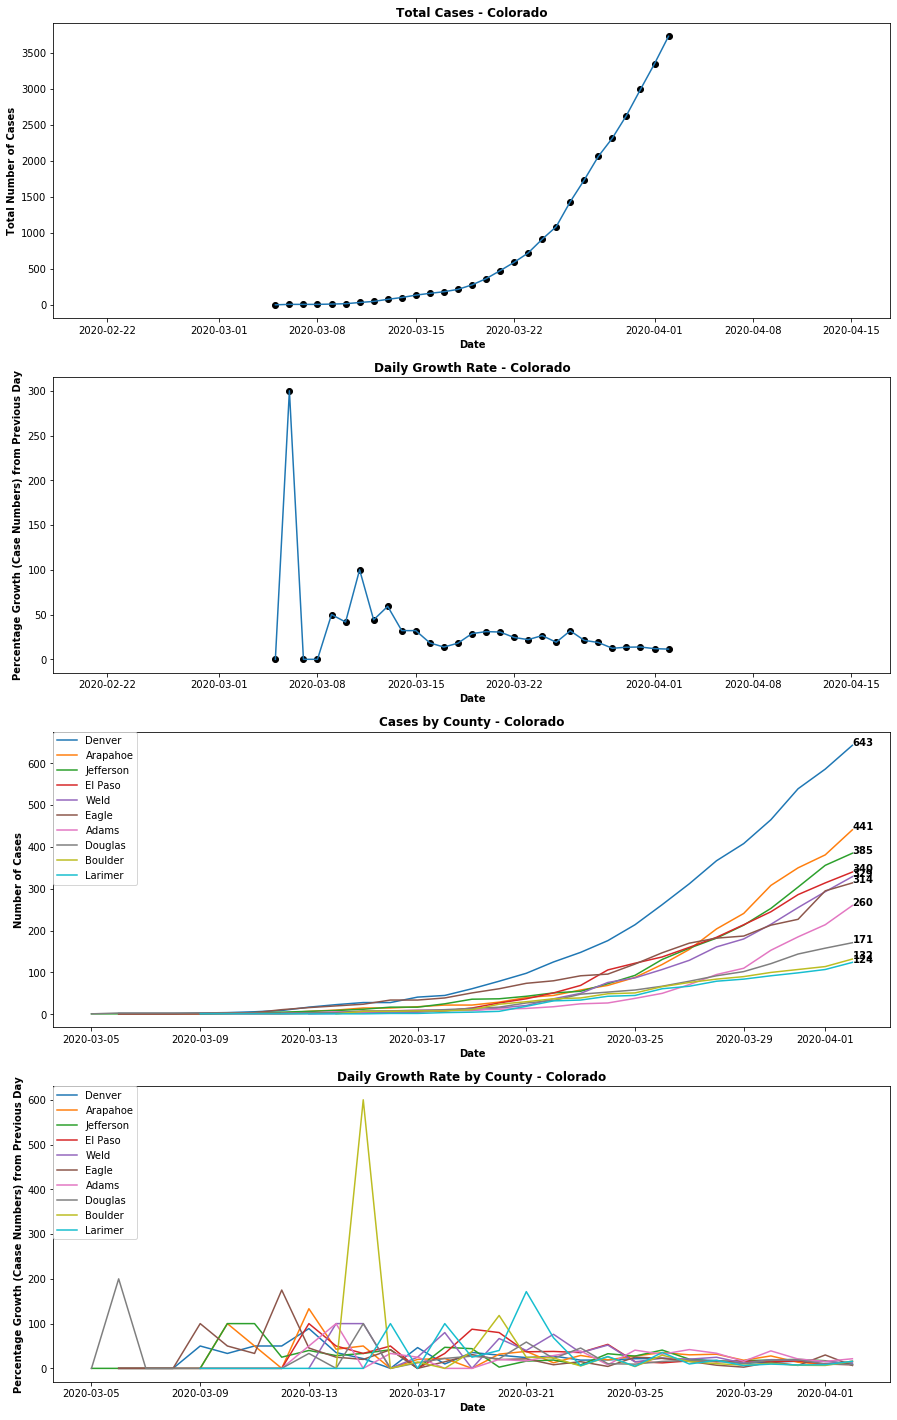

In [66]:
analyze_state("Colorado")

Illinois reported its first cases of COVID-19 on 2020-01-24 00:00:00, and has 7695 cases as of 2020-04-02 00:00:00

The previous daily growth rate was 10.24%

The 3 day average growth rate was 14.97%

The 7 day average growth rate was 17.33%

The 10 most effected counties in Illinois:


,county,first_case,total_cases,previous_day_growth_rate,3day_avg_growth_rate,7day_avg_growth_rate
0,Cook,2020-01-24,5575,8.21%,14.48%,16.82%
1,Lake,2020-03-11,540,13.21%,16.41%,16.62%
2,DuPage,2020-03-14,448,14.29%,11.88%,14.13%
3,Will,2020-03-16,384,19.25%,20.76%,29.61%
4,Kane,2020-03-10,154,8.45%,10.89%,15.53%
5,McHenry,2020-03-10,81,17.39%,16.02%,18.55%
6,Kankakee,2020-03-18,59,3.51%,16.16%,23.05%
7,St. Clair,2020-03-14,55,3.77%,15.49%,24.32%
8,Champaign,2020-03-22,43,30.3%,23.42%,27.83%
9,Kendall,2020-03-18,36,33.33%,27.0%,27.02%


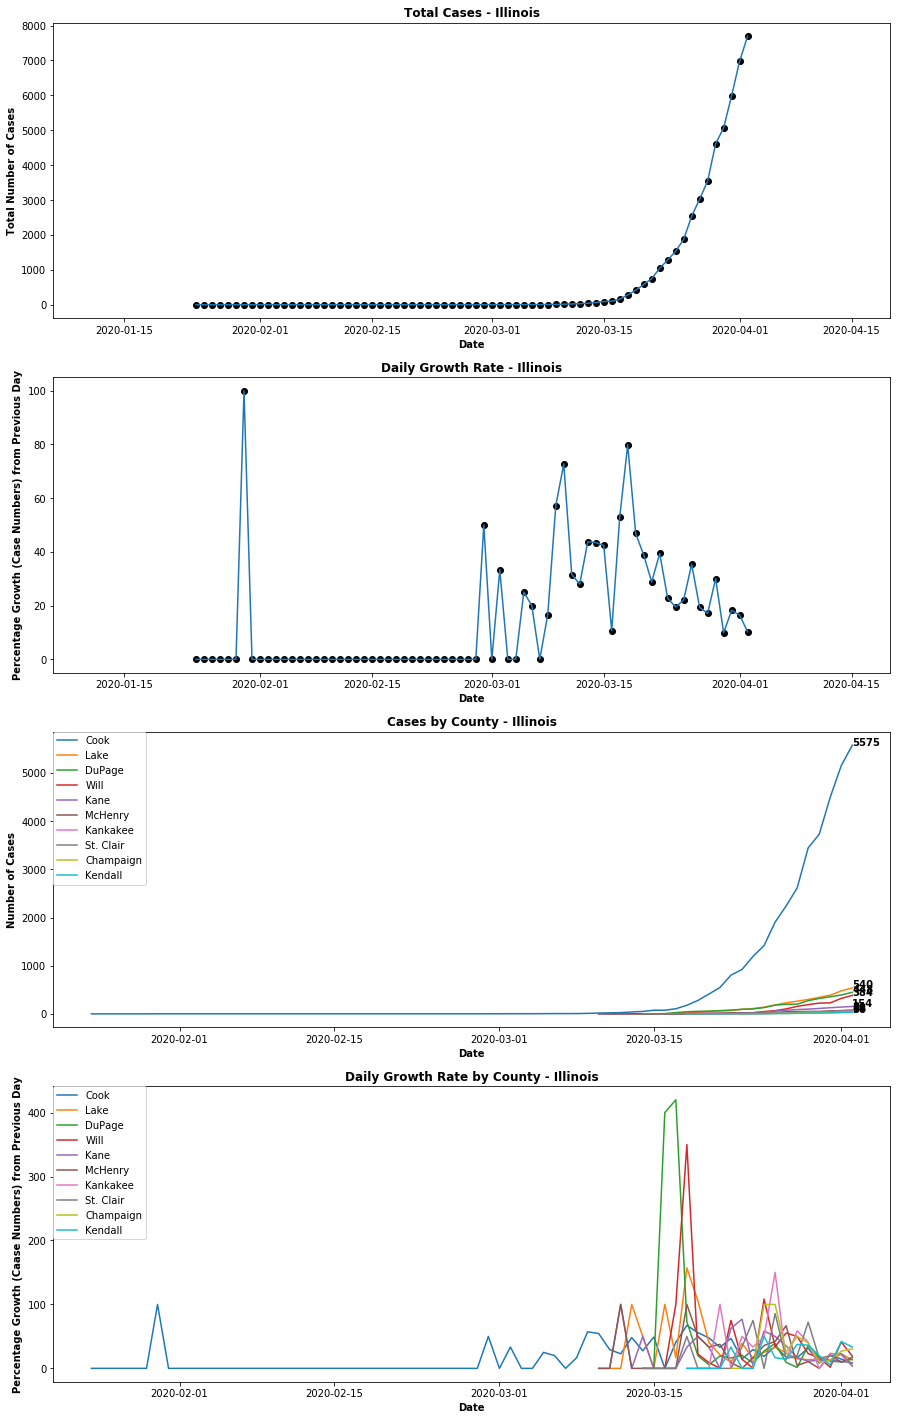

In [67]:
analyze_state("Illinois")

### GET N COUNTIES WITH MOST ACTIVE CASES

In [68]:
def get_most(county, n):
    
    most_recent = county[county.date == county.date.max()]
    
    hotspots = most_recent.sort_values(by = ["cases"], ascending = False).iloc[:n].fips
    
    fig, ax = plt.subplots(figsize = (15, 8))
    
    for cty in hotspots:
        
        county_dates = county[county.fips == cty].date
        
        county_cases = county[county.fips == cty].cases
        
        ax.scatter(county_dates, county_cases)

        ax.plot(county_dates, county_cases, label = county[county.fips == cty].county.max())
        
        ax.text(county_dates.iloc[-1], county_cases.iloc[-1], county_cases.iloc[-1],
                        horizontalalignment='left', weight = "bold")
        
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

    ax.set_title("{} Counties With Most Cases".format(n), weight = "bold")

    ax.set_xlabel("Date", weight = "bold")

    ax.set_ylabel("Number of Cases", weight = "bold");

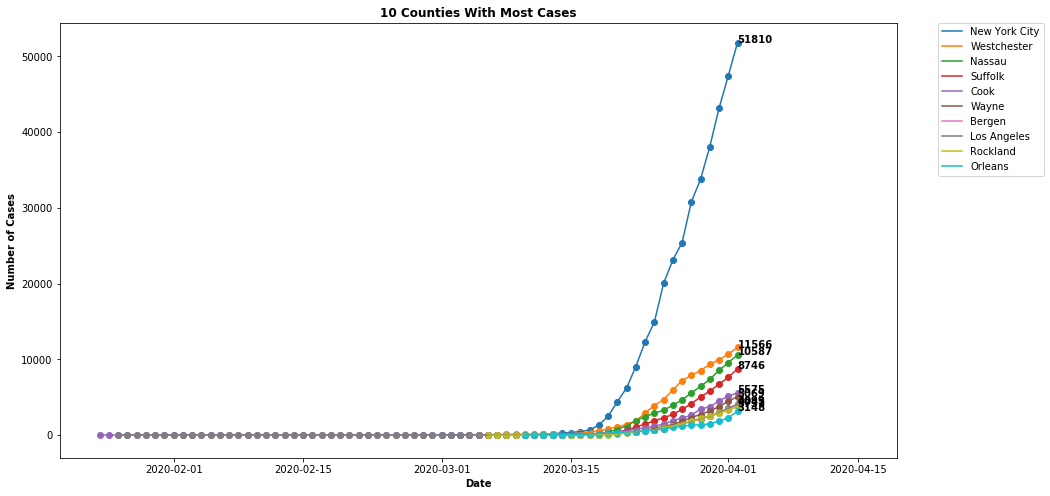

In [70]:
get_most(all_county, 10)

### EXPLORING TESTING DATA- COURTESY OF COVID TRACKING PROJECT

In [71]:
testing.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200403,AK,157.0,5859.0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,192f851a8f9b68576ed308814322d1333b538699,2020-04-03T20:00:00Z,3.0,15.0,6016,6016,6016,2,0.0,6.0,980.0,14.0,994.0
1,20200403,AL,1432.0,8187.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2321b8fce440dd33ac0feef0e923113ffffbf603,2020-04-03T20:00:00Z,35.0,NaN,9619,9619,9619,1,3.0,0.0,684.0,199.0,883.0
2,20200403,AR,704.0,8995.0,NaN,71.0,NaN,NaN,NaN,26.0,39.0,60.0,1668b119de8dbd14c4334330a55a40591b632995,2020-04-03T20:00:00Z,12.0,NaN,9699,9699,9699,5,0.0,0.0,1115.0,61.0,1176.0
3,20200403,AS,NaN,20.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3933c4281d22f25174ba2730269589d9da9bc026,2020-04-03T20:00:00Z,0.0,NaN,26,20,20,60,0.0,0.0,0.0,0.0,0.0
4,20200403,AZ,1769.0,22904.0,NaN,NaN,249.0,NaN,91.0,NaN,NaN,NaN,86d38836c9910dcfeb9ec4779c20c399d8da103d,2020-04-03T20:00:00Z,41.0,249.0,24673,24673,24673,4,9.0,21.0,1793.0,171.0,1964.0


In [72]:
testing["date"] = pd.to_datetime(testing.date, format = "%Y%m%d")

testing = testing.sort_values(by = ["state", "date"]).reset_index(drop = True)

In [73]:
pd.set_option("max.columns", 50)

testing.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,2020-03-06,AK,0.0,8.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b95ff00414e9a5542ba2aa08fdfda0b023c7c69c,2020-03-06T21:00:00Z,NaN,NaN,9,8,8,2,NaN,NaN,NaN,NaN,NaN
1,2020-03-07,AK,0.0,12.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71953eb42494f6000afda41cda80b1b3dc836a83,2020-03-07T21:00:00Z,NaN,NaN,14,12,12,2,0.0,0.0,4.0,0.0,4.0
2,2020-03-08,AK,0.0,14.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,844624448b0ee3ff7dd240e0d3f4258de1563064,2020-03-08T20:00:00Z,NaN,NaN,20,14,14,2,0.0,0.0,2.0,0.0,2.0
3,2020-03-09,AK,0.0,23.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b5cbe627dd51a6e70136134185391030f93ffcb5,2020-03-09T20:00:00Z,NaN,NaN,32,23,23,2,0.0,0.0,9.0,0.0,9.0
4,2020-03-10,AK,0.0,23.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6561feac0f53ef762911b4995038df195c62b2cb,2020-03-10T20:00:00Z,NaN,NaN,32,23,23,2,0.0,0.0,0.0,0.0,0.0


In [74]:
ca_testing = testing[testing.state == "CA"].reset_index(drop = True)

ca_testing.tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,hash,dateChecked,death,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
26,2020-03-30,CA,6447.0,20549.0,64400.0,1432.0,1432.0,597.0,597.0,NaN,NaN,NaN,b2fd37c8b374d544e8f30c2b619be88799980737,2020-03-30T20:00:00Z,133.0,1432.0,91396,26996,26996,6,10.0,398.0,0.0,739.0,739.0
27,2020-03-31,CA,7482.0,21772.0,57400.0,1617.0,1617.0,657.0,657.0,NaN,NaN,NaN,8aa120a4c2d14e4da8b37e1148edb1eec68c9797,2020-03-31T20:00:00Z,153.0,1617.0,86654,29254,29254,6,20.0,185.0,1223.0,1035.0,2258.0
28,2020-04-01,CA,8155.0,21772.0,57400.0,1855.0,1855.0,774.0,774.0,NaN,NaN,NaN,6fb93efce94c15c30e753005c45c7b45e390198c,2020-04-01T20:00:00Z,171.0,1855.0,87327,29927,29927,6,18.0,238.0,0.0,673.0,673.0
29,2020-04-02,CA,9191.0,23809.0,59500.0,1922.0,NaN,816.0,NaN,NaN,NaN,NaN,99877fe91b05bb13daef3f63c02c50d2a271e7f5,2020-04-02T20:00:00Z,203.0,NaN,92500,33000,33000,6,32.0,0.0,2037.0,1036.0,3073.0
30,2020-04-03,CA,10701.0,24599.0,59500.0,2188.0,NaN,901.0,NaN,NaN,NaN,NaN,67f105bfa3690e07b85e362a0c6c43aa796aba45,2020-04-03T20:00:00Z,237.0,NaN,94800,35300,35300,6,34.0,0.0,790.0,1510.0,2300.0


### Positive Result Rate: The ratio of n_positive / n_negative

NOTE: THIS IS THE RATIO OF POSITIVE TESTS TO TEST RESULTS... PENDING TESTS ARE NOT ACCOUNTED FOR AS THE DATA IS NOT COMPLETE


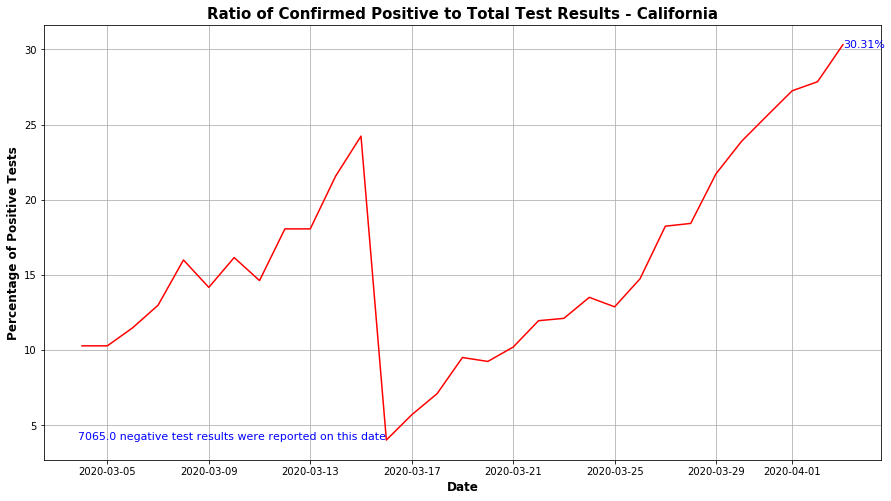

In [75]:
fig, ax = plt.subplots(figsize = (15, 8))

print("NOTE: THIS IS THE RATIO OF POSITIVE TESTS TO TEST RESULTS... PENDING TESTS ARE NOT\
 ACCOUNTED FOR AS THE DATA IS NOT COMPLETE")

ax.plot(ca_testing.date, (ca_testing.positive / ca_testing.totalTestResults) * 100, c = "r", label = "Pos/Neg Ratio")

x_coord = ca_testing.iloc[12]["date"]

y_coord = (ca_testing.iloc[12]["positive"] / ca_testing.iloc[12]["totalTestResults"]) * 100

s = "{} negative test results were reported on this date".format(
    ca_testing.iloc[12]["negative"] - ca_testing.iloc[11]["negative"])

ax.text(x_coord, y_coord, s, horizontalalignment='right', c = "b", size = 11)

ax.text(ca_testing.date.max(), (ca_testing.iloc[-1]["positive"] / ca_testing.iloc[-1]["totalTestResults"]) * 100,
        "{}%".format(round((ca_testing.iloc[-1]["positive"] / ca_testing.iloc[-1]["totalTestResults"]) * 100,
                          2)), horizontalalignment = "left", verticalalignment = "center", c = "b", size = 11)

ax.grid(True)

ax.set_title("Ratio of Confirmed Positive to Total Test Results - California", 
             weight = "bold", size = 15)

ax.set_xlabel("Date", weight = "bold", size = 12)

ax.set_ylabel("Percentage of Positive Tests", weight = "bold",
             size = 12);